# 🎸 MAPLE Audio Analysis - Performance Comparison

This notebook demonstrates the core audio analysis and comparison functionality used in the MAPLE Audio Analysis Server. It compares a user's guitar performance with a reference recording and/or MIDI file to evaluate:

- Pitch accuracy
- Rhythm/timing accuracy
- Playing techniques (bends, hammer-ons, pull-offs, etc.)
- Overall performance score

## Features
- Dynamic Time Warping (DTW) alignment of performances
- MIDI-based segmentation
- CREPE pitch detection
- Guitar technique classification
- Visualization of results

Last updated: April 18, 2025

## 1. Import Libraries

First, we'll import all the necessary libraries for audio processing, ML inference, and visualization.

In [17]:
import os
import numpy as np
import librosa
import random
import time
import h5py
import psutil
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
# TensorFlow/Keras 임포트 수정
import keras
from keras import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Dense, BatchNormalization, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.losses import BinaryFocalCrossentropy
from keras.metrics import F1Score
from keras.models import load_model

# If using pre-trained models like EfficientNet
try:
    from keras.applications import EfficientNetB0
except ImportError:
    # Fallback for older versions
    from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import crepe
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pretty_midi

# TensorFlow 로깅 설정
tf.get_logger().setLevel('ERROR')

## 2. MIDI Processing Functions

These functions extract note information from MIDI files, which serve as our "ground truth" for performance evaluation.

In [18]:
def parse_midi(midi_path):
    """Parse a MIDI file to extract notes, tempo and time information.
    
    Args:
        midi_path (str): Path to the MIDI file
        
    Returns:
        tuple: (notes, tempos, tempo_times) where:
            - notes: List of dictionaries containing note information (start, end, pitch, velocity)
            - tempos: List of tempo values in BPM
            - tempo_times: List of times where tempo changes occur
    """
    midi_data = pretty_midi.PrettyMIDI(midi_path)
    notes = []
    for instrument in midi_data.instruments:
        print(f"Instrument: {instrument.name}, Program: {instrument.program}, Is Drum: {instrument.is_drum}")
        for note in instrument.notes:
            notes.append({
                'start': note.start,
                'end': note.end,
                'pitch': note.pitch,
                'velocity': note.velocity
            })
    tempo_changes = midi_data.get_tempo_changes()
    tempos = tempo_changes[1]
    tempo_times = tempo_changes[0]
    if notes:
        start_times = [note['start'] for note in notes]
        print(f"Parsed {len(notes)} notes from MIDI file.")
        print(f"MIDI note start times range: {min(start_times):.2f}s to {max(start_times):.2f}s")
    else:
        print("No notes found in MIDI file.")
    return notes, tempos, tempo_times

## 3. Audio Alignment Using DTW

Dynamic Time Warping (DTW) aligns the user's recording with the reference audio, compensating for differences in timing and speed.

In [19]:
def extract_chroma(audio_path, sr=22050):
    """Extract chroma features from audio for alignment.
    
    Args:
        audio_path (str): Path to the audio file
        sr (int): Sample rate for loading audio
        
    Returns:
        tuple: (chroma, y, sr) - chroma features, audio signal, and sample rate
    """
    y, sr = librosa.load(audio_path, sr=sr)
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=2048)
    return chroma, y, sr

def align_audio_with_dtw(user_audio_path, original_audio_path, sr=22050):
    """Align user audio with reference audio using DTW.
    
    Args:
        user_audio_path (str): Path to the user's audio recording
        original_audio_path (str): Path to the reference audio
        sr (int): Sample rate
        
    Returns:
        tuple: (time_mapping, user_y, orig_y, sr) where time_mapping is a list of (user_time, orig_time) pairs
    """
    user_chroma, user_y, _ = extract_chroma(user_audio_path, sr)
    orig_chroma, orig_y, _ = extract_chroma(original_audio_path, sr)
    distance, path = fastdtw(user_chroma.T, orig_chroma.T, dist=euclidean)
    
    # Calculate audio file durations
    user_duration = librosa.get_duration(y=user_y, sr=sr)
    orig_duration = librosa.get_duration(y=orig_y, sr=sr)
    
    # Create time arrays for chroma features
    user_times = librosa.frames_to_time(np.arange(user_chroma.shape[1]), sr=sr, hop_length=2048)
    orig_times = librosa.frames_to_time(np.arange(orig_chroma.shape[1]), sr=sr, hop_length=2048)
    
    # Create time mapping based on DTW path
    time_mapping = []
    for user_idx, orig_idx in path:
        user_time = user_times[user_idx] if user_idx < len(user_times) else user_duration
        orig_time = orig_times[orig_idx] if orig_idx < len(orig_times) else orig_duration
        time_mapping.append((user_time, orig_time))
    
    # Expand time mapping to cover full audio length (with linear interpolation)
    if time_mapping:
        # Sort by reference time
        time_mapping = sorted(time_mapping, key=lambda x: x[1])
        new_time_mapping = []
        last_user_time, last_orig_time = time_mapping[0]
        new_time_mapping.append((last_user_time, last_orig_time))
        
        for user_time, orig_time in time_mapping[1:]:
            if orig_time > last_orig_time:
                new_time_mapping.append((user_time, orig_time))
                last_user_time, last_orig_time = user_time, orig_time
        
        # Create 1000 evenly spaced points with linear interpolation
        time_mapping = []
        orig_times = np.linspace(0, orig_duration, num=1000)
        user_times = np.interp(orig_times, [t[1] for t in new_time_mapping], [t[0] for t in new_time_mapping])
        for user_time, orig_time in zip(user_times, orig_times):
            time_mapping.append((user_time, orig_time))
    
    print(f"Time mapping range: {time_mapping[0][0]:.2f}s to {time_mapping[-1][0]:.2f}s (user), "
          f"{time_mapping[0][1]:.2f}s to {time_mapping[-1][1]:.2f}s (orig)")
    return time_mapping, user_y, orig_y, sr

def segment_audio_with_midi_notes(y, time_mapping, notes, sr=22050):
    """Segment audio based on MIDI note events.
    
    Args:
        y (numpy.ndarray): Audio signal
        time_mapping (list): List of (user_time, orig_time) pairs from DTW alignment
        notes (list): List of note dictionaries from MIDI
        sr (int): Sample rate
        
    Returns:
        tuple: (segments, timestamps) - audio segments and their start times
    """
    segments = []
    timestamps = []
    user_times = [user_time for user_time, _ in time_mapping]
    orig_times = [orig_time for _, orig_time in time_mapping]
    
    for note in notes:
        start_time = note['start']
        end_time = note['end']
        
        # Map original time to user time with linear interpolation
        if start_time < orig_times[0]:
            user_start_time = user_times[0]
        elif start_time > orig_times[-1]:
            user_start_time = user_times[-1]
        else:
            idx = np.searchsorted(orig_times, start_time)
            if idx == 0:
                user_start_time = user_times[0]
            elif idx == len(orig_times):
                user_start_time = user_times[-1]
            else:
                t0, t1 = orig_times[idx-1], orig_times[idx]
                u0, u1 = user_times[idx-1], user_times[idx]
                user_start_time = u0 + (start_time - t0) * (u1 - u0) / (t1 - t0)
        
        duration = end_time - start_time
        user_end_time = user_start_time + duration
        start_sample = int(user_start_time * sr)
        end_sample = int(user_end_time * sr)
        
        if start_sample >= len(y):
            continue  # Skip if beyond audio length
        
        if end_sample > len(y):
            segment = np.pad(y[start_sample:], (0, end_sample - len(y)), mode='constant')
        else:
            segment = y[start_sample:end_sample]
        
        segments.append(segment)
        timestamps.append(user_start_time)
    
    return segments, timestamps

## 4. Feature Extraction

These functions extract musical features (pitch, tempo, onsets) from both the user's recording and the reference audio.

In [20]:
def extract_pitch_with_crepe(segments, sr=22050):
    """Extract pitch information using CREPE model.
    
    Args:
        segments (list): List of audio segments
        sr (int): Sample rate
        
    Returns:
        list: Average pitch frequencies for each segment
    """
    pitches = []
    for segment in segments:
        if len(segment) < sr * 0.01:  # Skip segments that are too short
            pitches.append(0)
            continue
        time, frequency, confidence, activation = crepe.predict(segment, sr, viterbi=True)
        avg_freq = np.mean(frequency[confidence > 0.5]) if np.any(confidence > 0.5) else 0
        pitches.append(avg_freq if not np.isnan(avg_freq) else 0)
    return pitches

def compare_pitches(user_segments, orig_segments, sr=22050):
    """Compare pitch between user and reference segments.
    
    Args:
        user_segments (list): List of user audio segments
        orig_segments (list): List of reference audio segments
        sr (int): Sample rate
        
    Returns:
        tuple: (user_pitches, orig_pitches)
    """
    user_pitches = extract_pitch_with_crepe(user_segments, sr)
    orig_pitches = extract_pitch_with_crepe(orig_segments, sr)
    return user_pitches, orig_pitches

def extract_onsets(audio_path, sr=22050):
    """Extract onset times from audio.
    
    Args:
        audio_path (str): Path to audio file
        sr (int): Sample rate
        
    Returns:
        numpy.ndarray: Array of onset times in seconds
    """
    y, sr = librosa.load(audio_path, sr=sr)
    onset_frames = librosa.onset.onset_detect(y=y, sr=sr, backtrack=True)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    return onset_times

def compare_onsets(user_audio_path, original_audio_path, time_mapping, notes, sr=22050):
    """Compare onsets between user and reference audio.
    
    Args:
        user_audio_path (str): Path to user audio
        original_audio_path (str): Path to reference audio
        time_mapping (list): Time mapping from DTW
        notes (list): MIDI notes
        sr (int): Sample rate
        
    Returns:
        tuple: User onsets, reference onsets, MIDI onsets, and their differences
    """
    user_onsets = extract_onsets(user_audio_path, sr)
    orig_onsets = extract_onsets(original_audio_path, sr)
    midi_onsets = [note['start'] for note in notes]
    user_times = [user_time for user_time, _ in time_mapping]
    orig_times = [orig_time for _, orig_time in time_mapping]

    # Calculate mapped onsets for comparison
    user_onsets_mapped = []
    orig_onsets_mapped = []
    midi_onsets_mapped = []
    
    for user_onset, orig_onset in zip(user_onsets, orig_onsets):
        user_idx = np.argmin(np.abs(np.array(user_times) - user_onset))
        orig_idx = np.argmin(np.abs(np.array(orig_times) - orig_onset))
        user_time = user_times[user_idx]
        orig_time = orig_times[orig_idx]
        midi_idx = np.argmin(np.abs(np.array(midi_onsets) - orig_time))
        if abs(user_time - orig_time) < 0.5:  # Only include if reasonably close
            user_onsets_mapped.append(user_time)
            orig_onsets_mapped.append(orig_time)
            midi_onsets_mapped.append(midi_onsets[midi_idx])

    # Calculate onset timing differences
    user_onset_differences = []
    orig_onset_differences = []
    for user_time, orig_time, midi_time in zip(user_onsets_mapped, orig_onsets_mapped, midi_onsets_mapped):
        user_diff = abs(user_time - midi_time)
        orig_diff = abs(orig_time - midi_time)
        user_onset_differences.append(user_diff)
        orig_onset_differences.append(orig_diff)

    return user_onsets, orig_onsets, midi_onsets, user_onset_differences, orig_onset_differences

def extract_tempo(audio_path, sr=22050):
    """Extract tempo information from audio.
    
    Args:
        audio_path (str): Path to audio file
        sr (int): Sample rate
        
    Returns:
        float: Estimated tempo in BPM
    """
    y, sr = librosa.load(audio_path, sr=sr)
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr)
    return tempo.item()

def compare_tempo(user_audio_path, original_audio_path, tempos, sr=22050):
    """Compare tempo between user and reference audio.
    
    Args:
        user_audio_path (str): Path to user audio
        original_audio_path (str): Path to reference audio
        tempos (list): Tempo values from MIDI
        sr (int): Sample rate
        
    Returns:
        tuple: User tempo, reference tempo, MIDI tempo, and their differences
    """
    user_tempo = extract_tempo(user_audio_path, sr)
    orig_tempo = extract_tempo(original_audio_path, sr)
    midi_tempo = tempos[0]
    user_tempo_diff = abs(user_tempo - midi_tempo)
    orig_tempo_diff = abs(orig_tempo - midi_tempo)
    return user_tempo, orig_tempo, midi_tempo, user_tempo_diff, orig_tempo_diff

## 5. Guitar Technique Detection

These functions detect playing techniques (bend, hammer-on, pull-off, slide, vibrato) using a pre-trained CNN model.

In [21]:
def wav_to_spectrogram(y, sr=22050, n_fft=512, hop_length=20, n_mels=128, target_time_frames=960):
    """Convert audio to mel spectrogram for technique detection.
    
    Args:
        y (numpy.ndarray): Audio signal
        sr (int): Sample rate
        n_fft (int): FFT window size
        hop_length (int): Hop length
        n_mels (int): Number of mel bands
        target_time_frames (int): Target number of time frames (for standardization)
        
    Returns:
        numpy.ndarray: Mel spectrogram
    """
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    S_db = librosa.power_to_db(S, ref=np.max)
    
    # Standardize spectrogram size
    if S_db.shape[1] < target_time_frames:
        S_db = np.pad(S_db, ((0, 0), (0, target_time_frames - S_db.shape[1])), mode='constant')
    elif S_db.shape[1] > target_time_frames:
        S_db = S_db[:, :target_time_frames]
    
    return S_db

def predict_techniques(segments, model, sr=22050):
    """Predict guitar techniques used in audio segments.
    
    Args:
        segments (list): List of audio segments
        model: Keras model for technique classification
        sr (int): Sample rate
        
    Returns:
        list: List of predicted techniques for each segment
    """
    techniques = ["bend", "hammer", "normal", "pull", "slide", "vibrato"]
    predictions = []
    
    for segment in segments:
        if len(segment) < sr * 0.01:  # Skip if too short
            predictions.append(["unknown"])
            continue
            
        spec = wav_to_spectrogram(segment, sr=sr)
        spec = (spec - np.min(spec)) / (np.max(spec) - np.min(spec) + 1e-8)  # Normalize
        spec = spec[..., np.newaxis]  # Add channel dimension
        spec = np.expand_dims(spec, axis=0)  # Add batch dimension
        
        pred = model.predict(spec, verbose=0)
        pred_binary = (pred > 0.5).astype(int)
        predicted_techniques = [techniques[i] for i in range(len(pred_binary[0])) if pred_binary[0][i] == 1]
        
        predictions.append(predicted_techniques if predicted_techniques else ["normal"])
    
    return predictions

def compare_techniques(user_segments, orig_segments, model, sr=22050):
    """Compare guitar techniques between user and reference segments.
    
    Args:
        user_segments (list): List of user audio segments
        orig_segments (list): List of reference audio segments
        model: Keras model for technique classification
        sr (int): Sample rate
        
    Returns:
        tuple: User techniques, reference techniques, and technique matches
    """
    user_techniques = predict_techniques(user_segments, model, sr)
    orig_techniques = predict_techniques(orig_segments, model, sr)
    
    technique_matches = []
    for user_tech, orig_tech in zip(user_techniques, orig_techniques):
        match = set(user_tech) == set(orig_tech)
        technique_matches.append(match)
        
    return user_techniques, orig_techniques, technique_matches

## 6. Results Integration and Visualization

These functions combine and visualize all the analysis results.

In [22]:
def integrate_results(note_timestamps, user_pitches, orig_pitches, user_techniques, orig_techniques, 
                      technique_matches, user_tempo, orig_tempo, midi_tempo, user_tempo_diff, 
                      orig_tempo_diff, user_onsets, orig_onsets, midi_onsets, 
                      user_onset_differences, orig_onset_differences):
    """Integrate all analysis results into a comprehensive report.
    
    Args:
        Various analysis results from previous functions
        
    Returns:
        tuple: DataFrame with note-by-note results and lists of onsets
    """
    # Create a note-by-note comparison table
    results = []
    for i, (timestamp, user_pitch, orig_pitch, tech_match) in enumerate(zip(note_timestamps, user_pitches, orig_pitches, technique_matches)):
        pitch_diff = abs(user_pitch - orig_pitch) if user_pitch != 0 and orig_pitch != 0 else "N/A"
        
        # Format pitch in Hz and calculate cents difference if applicable
        cents_diff = "N/A"
        if isinstance(pitch_diff, (int, float)) and pitch_diff != "N/A":
            cents_diff = 1200 * np.log2(user_pitch / orig_pitch) if user_pitch > 0 and orig_pitch > 0 else "N/A"
            if isinstance(cents_diff, (int, float)):
                cents_diff = f"{abs(cents_diff):.1f} cents"
        
        result = {
            "Note #": i + 1,
            "Time (s)": f"{timestamp:.2f}",
            "User Pitch (Hz)": f"{user_pitch:.1f}" if user_pitch != 0 else "N/A",
            "Reference Pitch (Hz)": f"{orig_pitch:.1f}" if orig_pitch != 0 else "N/A",
            "Pitch Difference": cents_diff,
            "Technique Match": "✓" if tech_match else "✗",
            "User Techniques": ", ".join(user_techniques[i]),
            "Reference Techniques": ", ".join(orig_techniques[i])
        }
        results.append(result)

    results_df = pd.DataFrame(results)
    
    # Print note-by-note comparison
    print("📊 Note-by-Note Comparison Results:")
    print(results_df)

    # Print tempo comparison
    print(f"\n🎵 Tempo Comparison:")
    print(f"User Tempo: {user_tempo:.1f} BPM")
    print(f"Reference Tempo: {orig_tempo:.1f} BPM")
    print(f"MIDI Tempo: {midi_tempo:.1f} BPM")
    print(f"User vs MIDI Difference: {user_tempo_diff:.1f} BPM")
    print(f"Reference vs MIDI Difference: {orig_tempo_diff:.1f} BPM")

    # Calculate overall scores
    # Pitch score (based on cents difference)
    pitch_diffs = []
    for up, op in zip(user_pitches, orig_pitches):
        if up > 0 and op > 0:
            cents = abs(1200 * np.log2(up / op))
            pitch_diffs.append(min(1200, cents))  # Cap at 1200 cents (octave)
            
    pitch_score = 100 - (np.mean(pitch_diffs) / 1200 * 100 if pitch_diffs else 0)
    
    # Rhythm score (based on onset timing differences)
    absolute_rhythm_score = 0
    relative_rhythm_score = 0
    
    if user_onset_differences:
        absolute_rhythm_score = 100 - min(100, np.mean(user_onset_differences) * 100)
        
        # Calculate relative rhythm score
        if orig_onset_differences:
            # Calculate how much better/worse the user is compared to the reference
            relative_diffs = []
            for user_diff, orig_diff in zip(user_onset_differences, orig_onset_differences):
                # If reference performer was off by X seconds, user is only penalized if they're worse than X
                # If user is more accurate than reference, they get full points for that note
                relative_diff = max(0, user_diff - orig_diff)
                relative_diffs.append(relative_diff)
            
            relative_rhythm_score = 100 - min(100, np.mean(relative_diffs) * 100)
            
            # Weighted average of absolute and relative scores (60% relative, 40% absolute)
            rhythm_score = 0.4 * absolute_rhythm_score + 0.6 * relative_rhythm_score
        else:
            rhythm_score = absolute_rhythm_score
    else:
        rhythm_score = 0
    
    # Technique score
    technique_score = np.mean([100 if match else 0 for match in technique_matches]) if technique_matches else 0
    
    # Tempo score
    tempo_score = 100 - min(100, (user_tempo_diff / midi_tempo) * 100)
    
    # Overall score (weighted average)
    overall_score = 0.4 * pitch_score + 0.3 * rhythm_score + 0.2 * technique_score + 0.1 * tempo_score
    
    print(f"\n🏆 Performance Scores:")
    print(f"Pitch Accuracy: {pitch_score:.1f}%")
    
    # Print both absolute and relative rhythm scores
    print(f"Rhythm Accuracy (Absolute): {absolute_rhythm_score:.1f}%")
    print(f"Rhythm Accuracy (Relative to Reference): {relative_rhythm_score:.1f}%")
    print(f"Rhythm Accuracy (Combined): {rhythm_score:.1f}%")
    
    print(f"Technique Accuracy: {technique_score:.1f}%")
    print(f"Tempo Accuracy: {tempo_score:.1f}%")
    print(f"Overall Score: {overall_score:.1f}%")
    
    # Calculate and print the expressiveness similarity
    if orig_onset_differences:
        ref_avg_deviation = np.mean(orig_onset_differences)
        user_avg_deviation = np.mean(user_onset_differences)
        expression_similarity = 100 - min(100, abs(ref_avg_deviation - user_avg_deviation) * 200)
        print(f"Expressiveness Similarity: {expression_similarity:.1f}%")
        print(f"(How similar your timing deviations are to the reference performer's style)")
    
    # Add timing deviation data to the DataFrame for detailed analysis
    if len(user_onset_differences) == len(results_df) and len(orig_onset_differences) == len(results_df):
        results_df["User Timing Deviation (s)"] = [f"{diff:.3f}" for diff in user_onset_differences]
        results_df["Reference Timing Deviation (s)"] = [f"{diff:.3f}" for diff in orig_onset_differences]
        
        # Calculate if user was "better" or "worse" than reference for each note
        timing_comparisons = []
        for user_diff, orig_diff in zip(user_onset_differences, orig_onset_differences):
            if user_diff < orig_diff:
                timing_comparisons.append("Better ✓")
            elif user_diff > orig_diff:
                timing_comparisons.append("Worse ✗")
            else:
                timing_comparisons.append("Same =")
        
        results_df["Timing vs Reference"] = timing_comparisons
        
        print("\n📊 Detailed Timing Analysis:")
        print(results_df[["Note #", "Time (s)", "User Timing Deviation (s)", "Reference Timing Deviation (s)", "Timing vs Reference"]])

    return results_df, user_onsets, orig_onsets, midi_onsets

def visualize_results(note_timestamps, user_pitches, orig_pitches, user_onsets, orig_onsets, midi_onsets, audio_duration):
    """Visualize the analysis results with matplotlib.
    
    Args:
        Various analysis results from previous functions
        audio_duration (float): Duration of the audio in seconds
    """
    # Set up a modern style
    plt.style.use('seaborn-v0_8-darkgrid')
    
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), dpi=100)
    
    # 1. Pitch comparison plot
    ax1.plot(note_timestamps, user_pitches, 'o-', color='#3498db', label="User Performance", linewidth=2, markersize=8)
    ax1.plot(note_timestamps, orig_pitches, 'x--', color='#e74c3c', label="Reference Performance", linewidth=2, markersize=8)
    
    # Calculate MIDI note numbers for y-axis ticks
    midi_notes = []
    note_names = []
    for i in range(36, 85):  # E2 to C6 (common guitar range)
        freq = 440 * 2**((i - 69) / 12)  # A4 = 69, 440Hz
        midi_notes.append(freq)
        
        # Generate note names (C, C#, D, etc.)
        note_idx = i % 12
        octave = i // 12 - 1
        note_map = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
        note_names.append(f"{note_map[note_idx]}{octave}")
    
    # Only show some note names to avoid clutter
    step = 3
    ax1.set_yticks(midi_notes[::step])
    ax1.set_yticklabels(note_names[::step])
    
    ax1.set_title("Pitch Comparison", fontsize=16, pad=20)
    ax1.set_xlabel("Time (seconds)", fontsize=12)
    ax1.set_ylabel("Note", fontsize=12)
    ax1.legend(loc='upper right', frameon=True, fontsize=12)
    ax1.set_xlim(0, audio_duration)
    ax1.set_ylim(min(filter(lambda x: x > 0, user_pitches + orig_pitches)) * 0.9, 
                max(user_pitches + orig_pitches) * 1.1)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # 2. Onset/timing comparison plot
    onset_height = 0.8
    ax2.vlines(user_onsets, 0, onset_height, colors='#3498db', label="User Onsets", linewidth=2)
    ax2.vlines(orig_onsets, 0, onset_height * 0.8, colors='#e74c3c', label="Reference Onsets", linestyles='dashed', linewidth=2)
    ax2.vlines(midi_onsets, 0, onset_height * 0.6, colors='#2ecc71', label="MIDI Onsets", linestyles='dotted', linewidth=2)
    
    ax2.set_title("Timing Comparison", fontsize=16, pad=20)
    ax2.set_xlabel("Time (seconds)", fontsize=12)
    ax2.set_ylim(0, 1)
    ax2.set_xlim(0, audio_duration)
    ax2.legend(loc='upper right', frameon=True, fontsize=12)
    ax2.grid(True, linestyle='--', alpha=0.7)
    ax2.set_yticks([])
    
    plt.tight_layout(pad=3)
    plt.show()

## 7. Main Analysis Pipeline

This function runs the entire analysis pipeline, integrating all the components.

In [23]:
def run_pipeline(user_audio_path, original_audio_path, midi_path, model):
    """Run the complete analysis pipeline.
    
    Args:
        user_audio_path (str): Path to user's audio file
        original_audio_path (str): Path to reference audio file
        midi_path (str): Path to MIDI file
        model: Trained model for technique classification
    """
    print("🎸 MAPLE Audio Analysis Pipeline")
    print("="*50)
    
    # Get audio duration for visualization
    y, sr = librosa.load(user_audio_path, sr=22050)
    audio_duration = librosa.get_duration(y=y, sr=sr)
    print(f"▶️ Audio Duration: {audio_duration:.2f} seconds")
    print("-"*50)

    # 1. Parse MIDI file
    print("📄 Parsing MIDI reference data...")
    notes, tempos, tempo_times = parse_midi(midi_path)
    print("-"*50)

    # 2. Align audio using DTW
    print("⏱️ Aligning performances with DTW...")
    time_mapping, user_y, orig_y, sr = align_audio_with_dtw(user_audio_path, original_audio_path)
    
    # 3. Segment audio based on MIDI notes
    print("✂️ Segmenting audio based on MIDI notes...")
    user_segments, user_timestamps = segment_audio_with_midi_notes(user_y, time_mapping, notes, sr)
    orig_segments, orig_timestamps = segment_audio_with_midi_notes(orig_y, time_mapping, notes, sr)
    print(f"Created {len(user_segments)} segments for analysis")
    print("-"*50)

    # 4. Extract and compare pitch
    print("🎵 Analyzing pitch with CREPE...")
    user_pitches, orig_pitches = compare_pitches(user_segments, orig_segments, sr)

    # 5. Extract and compare onsets/rhythm
    print("🎯 Detecting note onsets...")
    user_onsets, orig_onsets, midi_onsets, user_onset_differences, orig_onset_differences = compare_onsets(
        user_audio_path, original_audio_path, time_mapping, notes, sr)

    # 6. Extract and compare tempo
    print("⏱️ Calculating tempo...")
    user_tempo, orig_tempo, midi_tempo, user_tempo_diff, orig_tempo_diff = compare_tempo(
        user_audio_path, original_audio_path, tempos, sr)

    # 7. Detect and compare techniques
    print("🧠 Classifying guitar techniques...")
    user_techniques, orig_techniques, technique_matches = compare_techniques(
        user_segments, orig_segments, model, sr)
    print("-"*50)

    # 8. Integrate results
    print("📊 Generating performance analysis results...")
    results_df, user_onsets, orig_onsets, midi_onsets = integrate_results(
        user_timestamps, user_pitches, orig_pitches,
        user_techniques, orig_techniques, technique_matches,
        user_tempo, orig_tempo, midi_tempo, user_tempo_diff, orig_tempo_diff,
        user_onsets, orig_onsets, midi_onsets, user_onset_differences, orig_onset_differences
    )

    # 9. Visualize results
    print("\n📈 Generating visualizations...")
    visualize_results(user_timestamps, user_pitches, orig_pitches, user_onsets, orig_onsets, midi_onsets, audio_duration)

## 8. Run the Analysis

Now let's run the pipeline on our test files. This will compare a user's guitar performance with a reference recording and calculate accuracy scores.

2025-04-18 22:09:40.066639: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


🎸 MAPLE Audio Analysis Pipeline
▶️ Audio Duration: 6.73 seconds
--------------------------------------------------
📄 Parsing MIDI reference data...
Instrument: Clean Guitar, Program: 27, Is Drum: False
Parsed 23 notes from MIDI file.
MIDI note start times range: 0.00s to 5.79s
--------------------------------------------------
⏱️ Aligning performances with DTW...


/home/lovel/develop/maple-audio-analyzer/venv/lib/python3.12/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Time mapping range: 0.00s to 6.69s (user), 0.00s to 8.08s (orig)
✂️ Segmenting audio based on MIDI notes...
Created 23 segments for analysis
--------------------------------------------------
🎵 Analyzing pitch with CREPE...
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 296ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 219ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 532ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/s

I0000 00:00:1744981820.216562   54482 service.cc:152] XLA service 0x7f2cf0050e90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744981820.216650   54482 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-04-18 22:10:20.275469: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1744981821.088290   54482 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


--------------------------------------------------
📊 Generating performance analysis results...
📊 Note-by-Note Comparison Results:
    Note # Time (s) User Pitch (Hz) Reference Pitch (Hz) Pitch Difference  \
0        1     0.00           694.8                714.6       48.4 cents   
1        2     0.32           660.7                680.1       50.0 cents   
2        3     0.83           741.8                750.4       20.1 cents   
3        4     1.03           882.1                876.9       10.2 cents   
4        5     1.24           629.8                598.6       87.9 cents   
5        6     1.66           693.9                712.9       46.9 cents   
6        7     1.98           666.5                676.5       26.0 cents   
7        8     2.48           742.8                757.3       33.7 cents   
8        9     2.69           882.3                884.2        3.6 cents   
9       10     2.90           585.0                599.6       42.7 cents   
10      11     3.34   

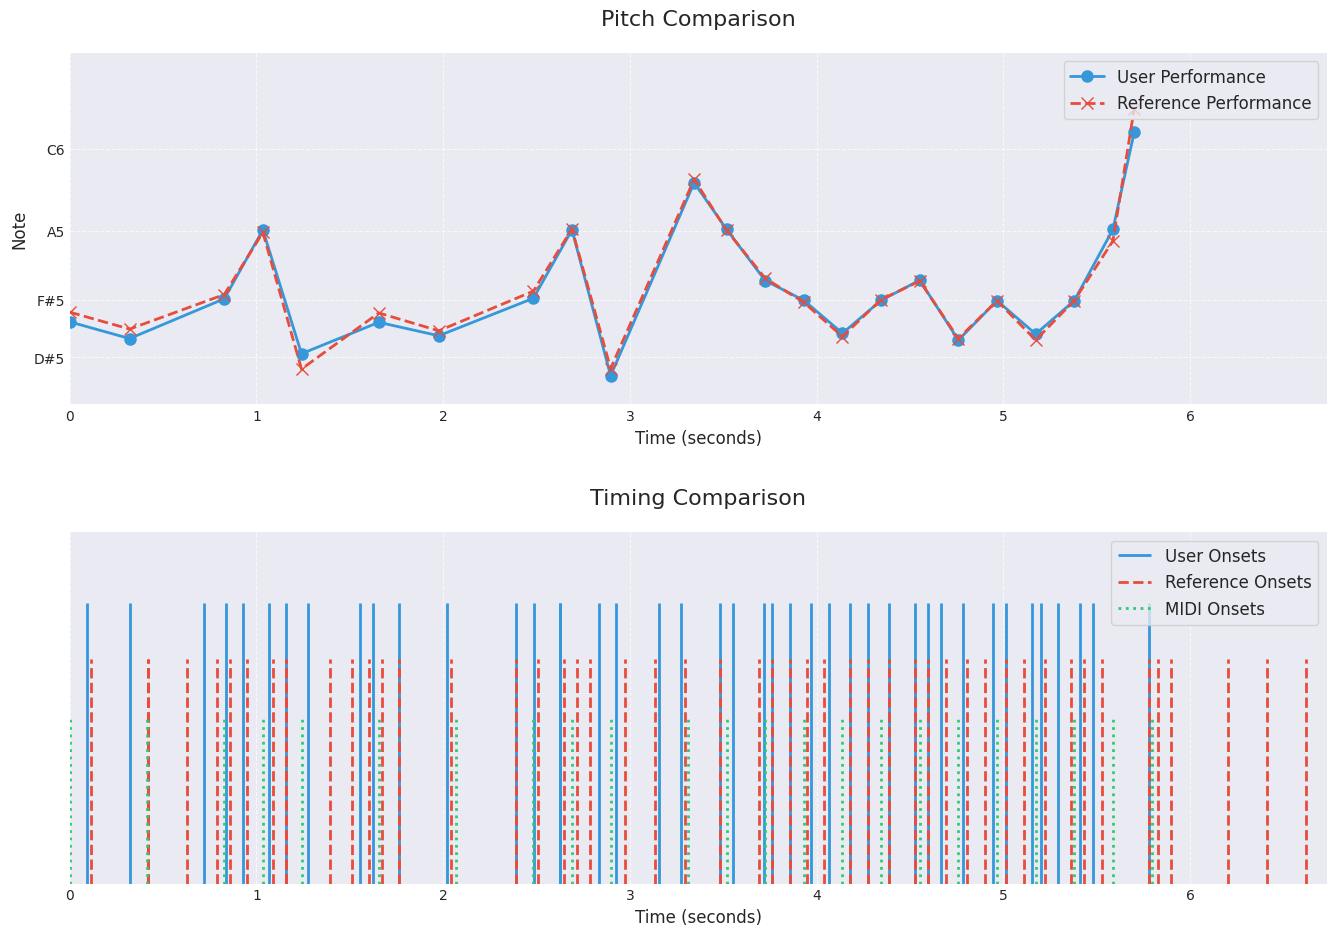

In [24]:
# Set paths to audio and MIDI files
user_audio_path = "test/error/homecoming-error-1.wav"
original_audio_path = "test/ref/homecoming.wav"
midi_path = "test/midi/homecoming.mid"

# Load the guitar technique classification model
model_path = "models/guitar_technique_classifier.keras"  # Using the model in the current directory
model = load_model(model_path)

# Run the analysis pipeline
run_pipeline(user_audio_path, original_audio_path, midi_path, model)

## 9. Conclusion

This notebook demonstrates the core functionality of the MAPLE Audio Analysis Server. It shows how we can:

1. Align a user's performance with a reference recording using DTW
2. Segment audio based on MIDI note events
3. Extract and compare musical features (pitch, rhythm, tempo, techniques)
4. Calculate performance scores
5. Visualize the results

The same functions are implemented in the server's codebase (`workers/dsp.py`) and are used by the Celery tasks to process audio files uploaded through the API.

### Next Steps

- Implement real-time WebSocket progress updates
- Add support for more instruments
- Improve technique detection for different playing styles
- Develop more detailed feedback mechanisms